In [1]:
%matplotlib ipympl

import json
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import matplotlib.patheffects as pe

import networkx as nx
import matplotlib.patches as mpatches

from learning.data.av_utils import collate_av_data
from learning.data.stateflow_utils import get_active_edges_mask, collate_stateflow_data
from matplotlib.colors import LinearSegmentedColormap
from learning.model.actionvalue import DWActionValueModel
from learning.data.av_dataset import ActionValueDataset
from learning.data.load_utils import load_dicewars_data
import torch
import random


In [2]:
history_folder = "server/history/"
history_files = sorted(glob.glob(os.path.join(history_folder, "history_*.json")))
history_file = history_files[random.randint(0, len(history_files))]
history_data = json.load(open(history_file, "r"))

In [3]:
node_positions = history_data["node_positions"] * np.array([[1, -1]])

graph_positions = {
    i: torch.tensor(node_pos)
    for i, node_pos in enumerate(node_positions)
}

adjacency_np = np.array(history_data["adjacency"])

n_nodes = adjacency_np.shape[0]

In [4]:
graph = nx.from_numpy_array(adjacency_np)

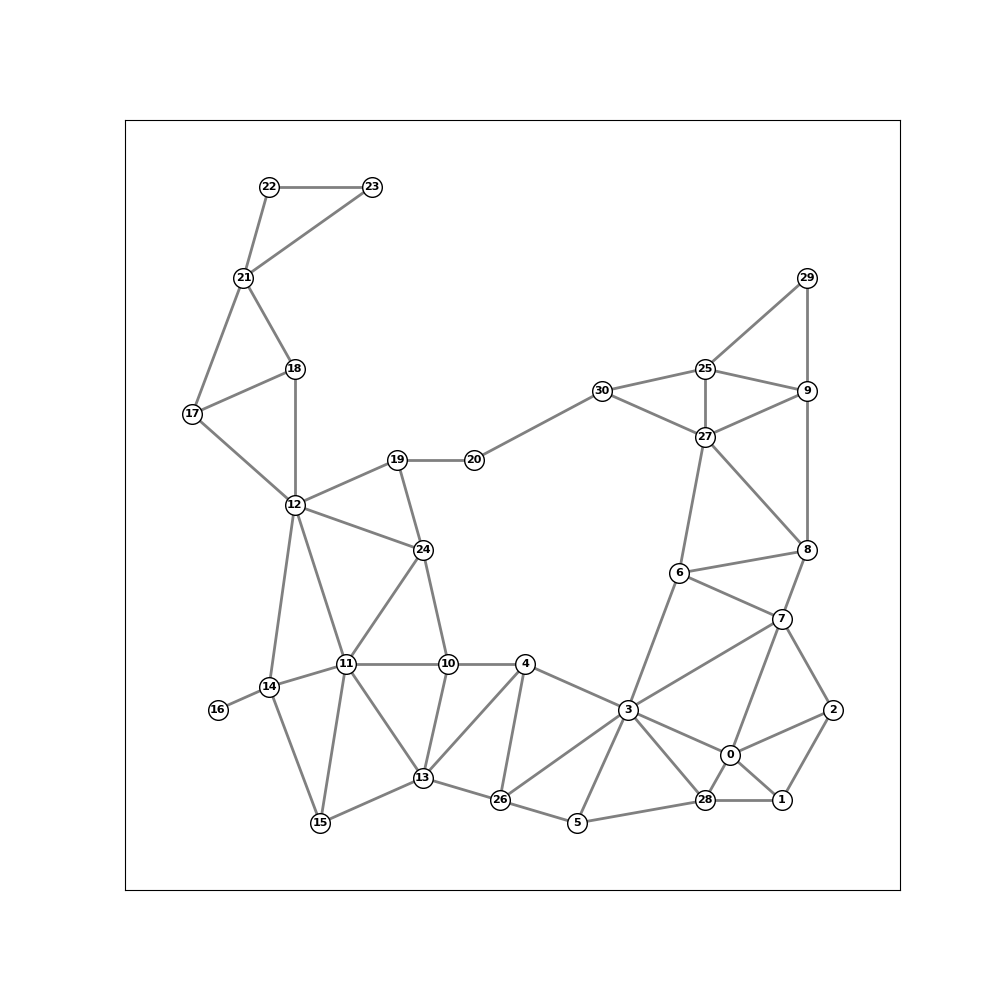

In [5]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))

nx.draw_networkx_edges(
    graph, 
    graph_positions,
    edgelist=graph.edges(),
    width=2,
    edge_color="grey",
    ax=ax
)

nx.draw_networkx_nodes(
    graph, 
    graph_positions,
    node_size=200,
    node_color="white",
    edgecolors="black",
    ax=ax
)

label_dict = { i: f"{i}" for i in range(n_nodes) }
_ = nx.draw_networkx_labels(
    graph, 
    graph_positions,
    labels=label_dict,
    font_size=8,
    font_weight="bold",
    font_color="black",
    ax=ax
)

## Laplacian Embedding

In [6]:
A = torch.tensor(adjacency_np)

In [7]:
D = torch.sum(A, dim=1)
D_inv_sqrt = 1 / torch.sqrt(D)

In [8]:
L_sym = torch.eye(A.shape[0]) \
    - D_inv_sqrt[:, torch.newaxis] * A * D_inv_sqrt[torch.newaxis, :]

In [9]:
eval, evec = torch.linalg.eigh(L_sym)

In [10]:
if eval[0] < 1e-6:
    eval = eval[1:]
    evec = evec[:, 1:]

In [11]:
ev_node_embedding = evec[:, :4]

In [12]:
ev_node_embedding

tensor([[-0.1869,  0.1625, -0.2569, -0.2266],
        [-0.1494,  0.1454, -0.2296, -0.2536],
        [-0.1551,  0.1131, -0.2131, -0.2559],
        [-0.1647,  0.1834, -0.1646,  0.1276],
        [-0.0064,  0.1922,  0.0475,  0.3201],
        [-0.0969,  0.1646, -0.1202,  0.1414],
        [-0.1772, -0.0683, -0.0509,  0.0360],
        [-0.1961,  0.0447, -0.1663, -0.1078],
        [-0.1931, -0.1659,  0.0029,  0.0438],
        [-0.2015, -0.3110,  0.1172,  0.1251],
        [ 0.0861,  0.1660,  0.1692,  0.1679],
        [ 0.1658,  0.1678,  0.2498,  0.0138],
        [ 0.2457,  0.0137,  0.1360, -0.2735],
        [ 0.0685,  0.2135,  0.1588,  0.3037],
        [ 0.1653,  0.1267,  0.2285, -0.1052],
        [ 0.1090,  0.1456,  0.1902,  0.0768],
        [ 0.0862,  0.0703,  0.1310, -0.0788],
        [ 0.2592, -0.1080, -0.1077, -0.1201],
        [ 0.2592, -0.1080, -0.1077, -0.1201],
        [ 0.0995, -0.0278,  0.1738, -0.3193],
        [-0.0071, -0.1246,  0.1537, -0.2549],
        [ 0.3613, -0.2238, -0.3119

In [ ]:
# eigenvalue ambiguity is resolved by making the largest component positive
max_idx = torch.argmax(torch.abs(ev_node_embedding), dim=0)
# Get the sign of the largest component
sign = torch.sign(ev_node_embedding[max_idx, :])
ev_node_embedding = ev_node_embedding * sign[torch.newaxis, :]

In [14]:
ev_node_embedding

tensor([[-0.1869, -0.1625,  0.2569, -0.2266],
        [-0.1494, -0.1454,  0.2296, -0.2536],
        [-0.1551, -0.1131,  0.2131, -0.2559],
        [-0.1647, -0.1834,  0.1646,  0.1276],
        [-0.0064, -0.1922, -0.0475,  0.3201],
        [-0.0969, -0.1646,  0.1202,  0.1414],
        [-0.1772,  0.0683,  0.0509,  0.0360],
        [-0.1961, -0.0447,  0.1663, -0.1078],
        [-0.1931,  0.1659, -0.0029,  0.0438],
        [-0.2015,  0.3110, -0.1172,  0.1251],
        [ 0.0861, -0.1660, -0.1692,  0.1679],
        [ 0.1658, -0.1678, -0.2498,  0.0138],
        [ 0.2457, -0.0137, -0.1360, -0.2735],
        [ 0.0685, -0.2135, -0.1588,  0.3037],
        [ 0.1653, -0.1267, -0.2285, -0.1052],
        [ 0.1090, -0.1456, -0.1902,  0.0768],
        [ 0.0862, -0.0703, -0.1310, -0.0788],
        [ 0.2592,  0.1080,  0.1077, -0.1201],
        [ 0.2592,  0.1080,  0.1077, -0.1201],
        [ 0.0995,  0.0278, -0.1738, -0.3193],
        [-0.0071,  0.1246, -0.1537, -0.2549],
        [ 0.3613,  0.2238,  0.3119

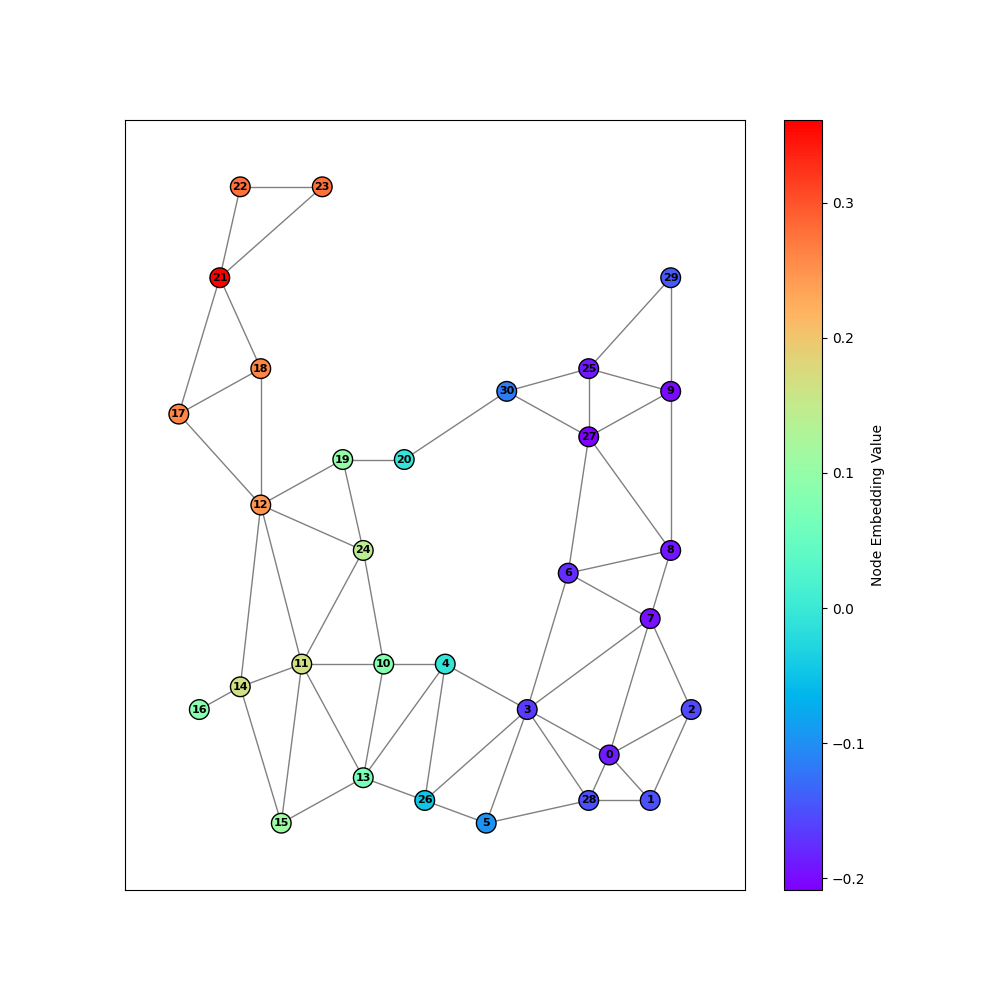

In [15]:
node_embedding = ev_node_embedding[:, 0]

f, ax = plt.subplots(1, 1, figsize=(10, 10))

nx.draw_networkx_edges(
    graph, 
    graph_positions,
    edgelist=graph.edges(),
    width=1,
    edge_color="grey",
    ax=ax
)

# Save the nodes collection to use for colorbar
nodes = nx.draw_networkx_nodes(
    graph, 
    graph_positions,
    node_size=200,
    edgecolors="black",
    cmap="rainbow",
    node_color=node_embedding.numpy(),
    ax=ax
)

label_dict = { i: f"{i}" for i in range(n_nodes) }
_ = nx.draw_networkx_labels(
    graph, 
    graph_positions,
    labels=label_dict,
    font_size=8,
    font_weight="bold",
    font_color="black",
    ax=ax
)

# Add colorbar
plt.colorbar(nodes, ax=ax, label="Node Embedding Value")

In [16]:
node_embedding = ev_node_embedding

Text(0, 0.5, 'Second Eigenvector')

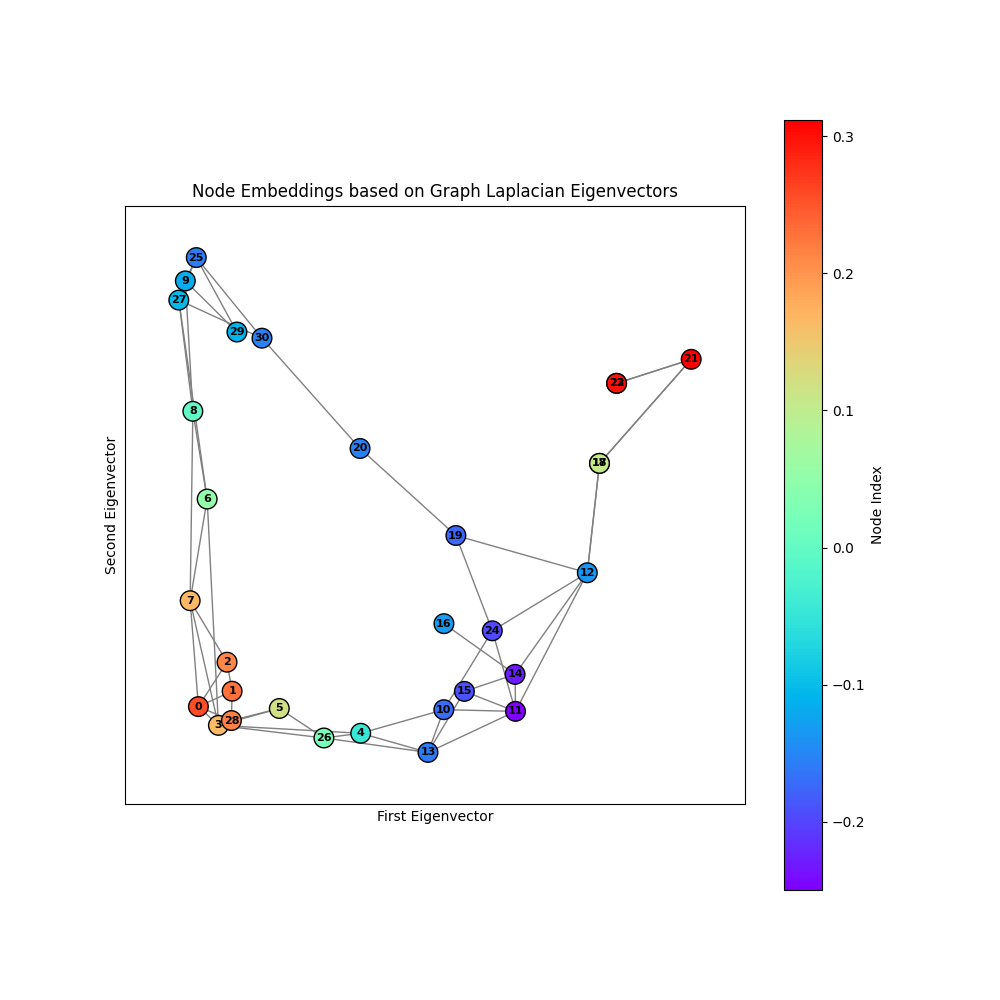

In [17]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))

graph_positions_emb = {
    i: node_embedding[i, slice(0, 2)] for i in range(n_nodes)
}

nx.draw_networkx_edges(
    graph, 
    graph_positions_emb,
    edgelist=graph.edges(),
    width=1,
    edge_color="grey",
    ax=ax
)

# Save the nodes collection to use for colorbar
nodes = nx.draw_networkx_nodes(
    graph, 
    graph_positions_emb,
    node_size=200,
    edgecolors="black",
    cmap="rainbow",
    node_color=node_embedding[:, 2].numpy(),
    ax=ax
)

label_dict = { i: f"{i}" for i in range(n_nodes) }
_ = nx.draw_networkx_labels(
    graph, 
    graph_positions_emb,
    labels=label_dict,
    font_size=8,
    font_weight="bold",
    font_color="black",
    ax=ax
)

    
# Add colorbar
plt.colorbar(nodes, ax=ax, label="Node Index")

# Set equal aspect ratio and labels
ax.set_aspect('equal')
ax.set_title("Node Embeddings based on Graph Laplacian Eigenvectors")
ax.set_xlabel("First Eigenvector")
ax.set_ylabel("Second Eigenvector")

In [18]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# Create a DataFrame with the node embeddings
df = pd.DataFrame({
    'x': node_embedding[:, 0],
    'y': node_embedding[:, 1],
    'z': node_embedding[:, 2],
    'color': node_embedding[:, 3],
    'node_id': [f"Node {i}" for i in range(n_nodes)]
})

# Create 3D scatter plot of nodes
fig = px.scatter_3d(
    df, x='x', y='y', z='z',
    color='color', 
    hover_name='node_id',
    size=[30] * n_nodes,
    opacity=0.8,
    color_continuous_scale='rainbow',
    title="3D Node Embeddings from Graph Laplacian Eigenvectors"
)

# Add edges as 3D lines
edges = graph.edges()
for edge in edges:
    i, j = edge
    # Create line for each edge
    fig.add_trace(
        go.Scatter3d(
            x=[node_embedding[i, 0], node_embedding[j, 0]],
            y=[node_embedding[i, 1], node_embedding[j, 1]],
            z=[node_embedding[i, 2], node_embedding[j, 2]],
            mode='lines',
            line=dict(color='gray', width=2),
            hoverinfo='none',
            showlegend=False
        )
    )

# Update layout
fig.update_layout(
    scene=dict(
        xaxis_title="Eigenvector 1",
        yaxis_title="Eigenvector 2",
        zaxis_title="Eigenvector 3",
        aspectmode='cube'
    ),
    coloraxis_colorbar=dict(title="Eigenvector 4 Value"),
    margin=dict(l=0, r=0, b=0, t=40)
);


In [19]:
fig

## Random Walk

In [20]:
P = 1 / D[:, torch.newaxis] * A

In [21]:
steps = [2,3,4,5,6,7,8,9]

rw_prob = []
for s in steps:
    rw_prob.append(torch.linalg.matrix_power(P, s))

In [22]:
rw_node_embedding = torch.tensor([
    [rw_prob[i][j, j] for i in range(len(steps))]
    for j in range(n_nodes)
])

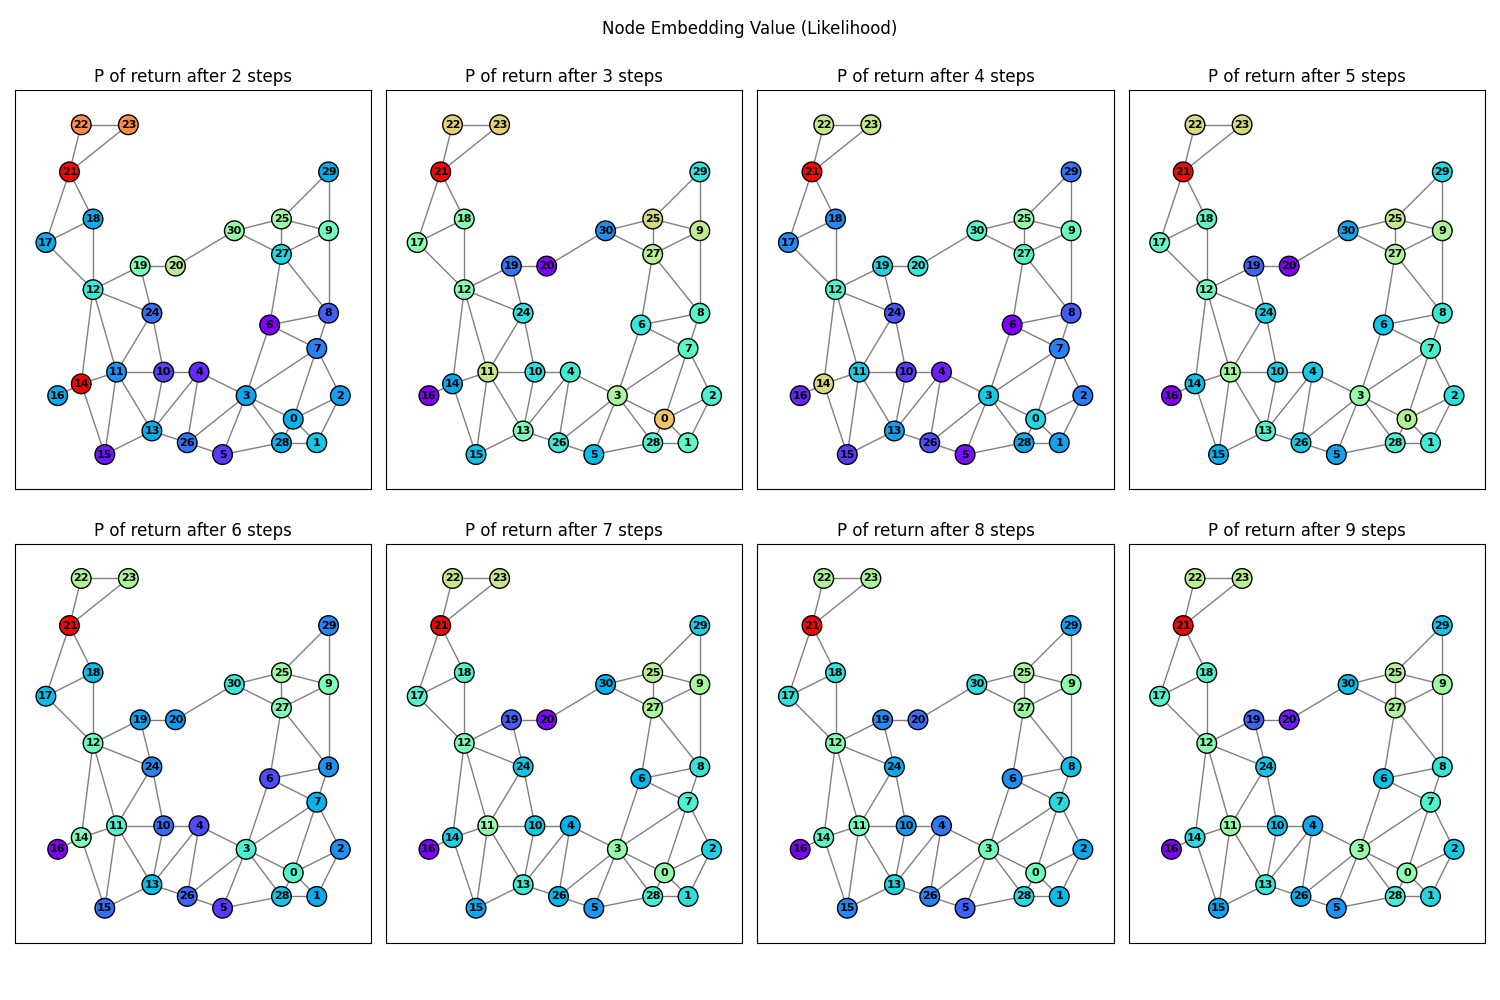

In [23]:
f, axes = plt.subplots(2, 4, figsize=(15, 10))
axes = axes.ravel()

vmin = rw_node_embedding.min()
vmax = rw_node_embedding.max()

for i, ax in enumerate(axes):
    nx.draw_networkx_edges(
        graph, 
        graph_positions,
        edgelist=graph.edges(),
        width=1,
        edge_color="grey",
        ax=ax
    )

    # Save the nodes collection to use for colorbar
    nodes = nx.draw_networkx_nodes(
        graph, 
        graph_positions,
        node_size=200,
        edgecolors="black",
        cmap="rainbow",
        # vmin=vmin,
        # vmax=vmax,
        node_color=rw_node_embedding[:, i].numpy(),
        ax=ax
    )

    label_dict = { i: f"{i}" for i in range(n_nodes) }
    _ = nx.draw_networkx_labels(
        graph, 
        graph_positions,
        labels=label_dict,
        font_size=8,
        font_weight="bold",
        font_color="black",
        ax=ax
    )
    ax.set_aspect(1)
    ax.set_title(f"P of return after {steps[i]} steps")
# Add suptitle first
f.suptitle("Node Embedding Value (Likelihood)")
# Then apply tight_layout
f.tight_layout()
# Adjust the top margin to make room for the title

Text(0, 0.5, '3-step-return')

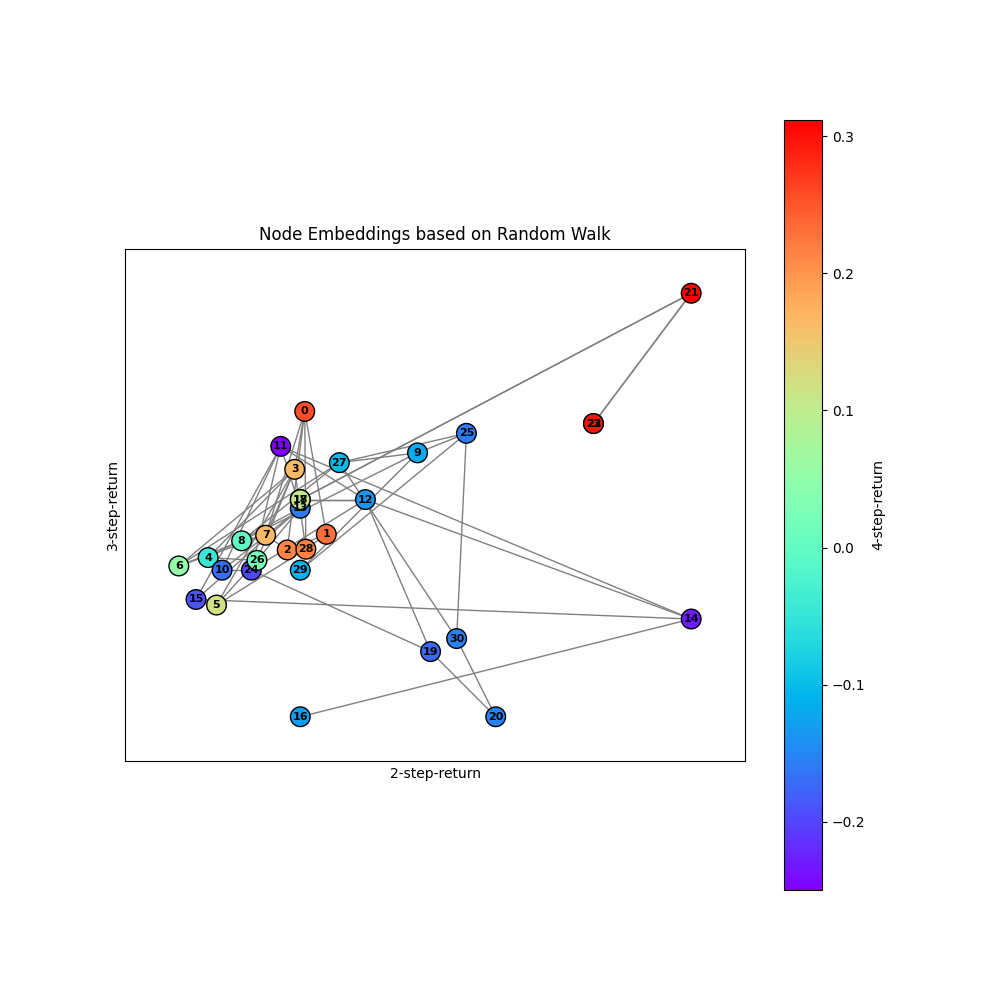

In [24]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))

graph_positions_emb = {
    i: rw_node_embedding[i, :2] for i in range(n_nodes)
}

nx.draw_networkx_edges(
    graph, 
    graph_positions_emb,
    edgelist=graph.edges(),
    width=1,
    edge_color="grey",
    ax=ax
)

# Save the nodes collection to use for colorbar
nodes = nx.draw_networkx_nodes(
    graph, 
    graph_positions_emb,
    node_size=200,
    edgecolors="black",
    cmap="rainbow",
    node_color=node_embedding[:, 2].numpy(),
    ax=ax
)

label_dict = { i: f"{i}" for i in range(n_nodes) }
_ = nx.draw_networkx_labels(
    graph, 
    graph_positions_emb,
    labels=label_dict,
    font_size=8,
    font_weight="bold",
    font_color="black",
    ax=ax
)

ax.set_aspect(1)
    
# Add colorbar
plt.colorbar(nodes, ax=ax, label=f"{steps[2]}-step-return")

# Set equal aspect ratio and labels
ax.set_aspect('equal')
ax.set_title("Node Embeddings based on Random Walk")
ax.set_xlabel(f"{steps[0]}-step-return")
ax.set_ylabel(f"{steps[1]}-step-return")

In [25]:
plt.close("all")